In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

In [2]:
n_samples = 1500
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)

In [3]:
moon_x, moon_y = noisy_moons
moon_x = StandardScaler().fit_transform(moon_x)

In [4]:
colors = np.array(
    list(
        islice(
            cycle(
                [
                    "#377eb8",
                    "#ff7f00",
                    "#4daf4a",
                    "#f781bf",
                ]
            ),
            int(max(moon_y) + 1),
        )
    )
)

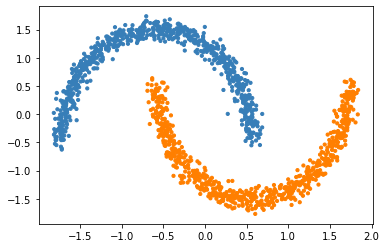

In [5]:
plt.scatter(moon_x[:,0], moon_x[:,1], color = colors[moon_y], s = 10)

In [6]:
import torch
import torch.nn as nn
import os, sys
from tony_dataset_2D import CTGdataset, CleanDataset
from neural_net_2D import Neural_Net, train_nn
torch.manual_seed(0)

In [7]:
Clean_Dataset = CleanDataset(moon_x, moon_y)

train_dataset, test_dataset = torch.utils.data.random_split(Clean_Dataset, 
    [int(0.9 * len(Clean_Dataset)), len(Clean_Dataset) - int(0.9 * len(Clean_Dataset))])
# training vs testing ratio is 6:4

In [8]:
grid_x = np.mgrid[-6:6:240j, -6:6:240j].reshape(2,-1).T
y = np.zeros(grid_x.shape[0])
grid_dataset = CleanDataset(grid_x, y)

In [9]:
def generate_data(model, test_dataset):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=len(test_dataset), 
                                            shuffle=True)
    # Iterate through test dataset, calculate testing accuracy
    for samples, labels in test_loader:
        outputs = model(samples)
        _, predicted = torch.max(outputs.data, 1)
    return samples, predicted

In [10]:
# Instantiate model class
input_dim = 2  # 2-dimensional space
hidden_dim = 30
output_dim = 2 # True or False - binary output
dropout_rate = 0.0
model = Neural_Net(input_dim, hidden_dim, output_dim, dropout_rate)

orig_stdout = sys.stdout

# Warmstart the neural networks
filepath = '../synthetic_data/2D/NN_generate_log.txt'
os.makedirs(os.path.dirname(filepath), exist_ok = True)

with open(filepath, 'w') as sys.stdout:
    batch_size = 50
    train_nn(model, train_dataset, test_dataset, batch_size = batch_size, l_r = 0.001, num_epochs = 100,
            optimizerName = "Adam")
    # Old comment
    # num_epochs is chosen to make the test accuracies of all 6 NN models to be less than 50%,
    # so that these models don't end up simply replicating the dataset

# Generate synthetic data with the neural networks
x, y = generate_data(model, grid_dataset)
x_df, y_df = pd.DataFrame(x.numpy()), pd.DataFrame(y.numpy())
x_df.to_csv('../synthetic_data/2D/NN_x.csv', index=False, header=False)
y_df.to_csv('../synthetic_data/2D/NN_y.csv', index=False, header=False)

sys.stdout = orig_stdout

In [11]:
for name, param in model.named_parameters():
    print (name)
    print(param.data)

fc1.weight
tensor([[-0.0205,  0.9647],
        [-0.6518,  0.3900],
        [-0.6618, -0.2588],
        [-0.6326, -0.0627],
        [ 0.8597, -0.1458],
        [ 0.8658,  0.0902],
        [ 0.0207, -0.8514],
        [-0.8756, -0.2021],
        [-1.0543, -0.1652],
        [ 0.0116, -0.0456],
        [-0.2259,  0.5809],
        [ 0.8401, -0.1538],
        [-0.4816,  0.4519],
        [ 0.5136, -0.7556],
        [-0.1528, -0.0656],
        [-0.3564,  0.6669],
        [-0.0125,  0.7229],
        [-0.0365, -0.0226],
        [-0.8068, -0.1139],
        [ 0.6262,  0.1750],
        [ 0.0405,  0.6538],
        [-0.5289,  0.2895],
        [ 0.9571, -0.0564],
        [ 0.9714,  0.1421],
        [-0.8971, -0.3189],
        [ 0.1919, -0.4145],
        [ 0.2289,  0.8419],
        [ 0.2402, -0.0662],
        [ 0.1021, -0.4789],
        [-0.8827, -0.5204]])
fc1.bias
tensor([-0.5289,  0.3164,  0.3000, -0.3441, -0.5229,  0.4818, -0.3554, -0.4251,
        -0.5616, -0.3989,  0.4909, -0.5129, -0.4537,  0.579

In [12]:
from torch.utils.tensorboard import SummaryWriter

# SummaryWriter.add_graph requires sample input data
trainloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=len(train_dataset), 
                                            shuffle=True)
dataiter = iter(trainloader)
features, labels = dataiter.next()

tb = SummaryWriter()
tb.add_graph(model, features)
tb.close()

In [13]:
NN_x = pd.read_csv("../synthetic_data/2D/NN_x.csv", header = None)
NN_y = pd.read_csv("../synthetic_data/2D/NN_y.csv", header = None)
NN_x, NN_y = np.array(NN_x), (np.array(NN_y)).flatten()

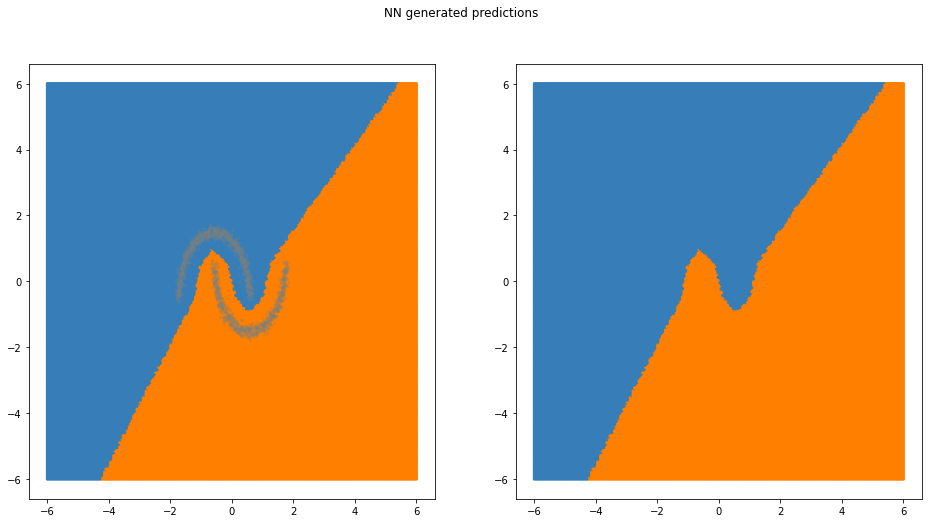

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('NN generated predictions')
fig

ax1.scatter(NN_x[:,0], NN_x[:,1], color = colors[NN_y], s = 5)
ax1.scatter(moon_x[:,0], moon_x[:,1], color = 'gray', s = 5, alpha = 0.2)

ax2.scatter(NN_x[:,0], NN_x[:,1], color = colors[NN_y], s = 5)

In [15]:
# context manager - used with "with" statement
# result: the added path is removed after execution of the indented block
class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            sys.path.remove(self.path)
        except ValueError:
            pass

In [16]:
with add_path('../'):
    from scikit_obliquetree.HHCART import HouseHolderCART
    from scikit_obliquetree.segmentor import MeanSegmentor, TotalSegmentor, Gini
    from sklearn.metrics import accuracy_score

    sgmtr = TotalSegmentor()
    HHTree = HouseHolderCART(impurity = Gini(), segmentor = sgmtr, max_depth = 5, min_samples = 10)
    HHTree.fit(moon_x, moon_y)
    nodes = HHTree._nodes
    train_score = accuracy_score(moon_y, HHTree.predict(moon_x))
    print("train_score: ", train_score)
    grid_y_pred = HHTree.predict(grid_x)
    grid_y_pred = grid_y_pred.astype(int)

train_score:  0.998


In [17]:
print(f"number of nodes on this tree: {len(nodes)}")
leaf_count = sum([1 if node.is_leaf else 0 for node in nodes])
print(f"number of leaf nodes: {leaf_count}")
print(f"root node depth: {HHTree._root.depth}")
print()
for node in nodes:
    if node.is_leaf:
        print(f"Leaf depth is: {node.depth}")

number of nodes on this tree: 25
number of leaf nodes: 13
root node depth: 0

Leaf depth is: 5
Leaf depth is: 5
Leaf depth is: 4
Leaf depth is: 5
Leaf depth is: 5
Leaf depth is: 4
Leaf depth is: 2
Leaf depth is: 4
Leaf depth is: 4
Leaf depth is: 3
Leaf depth is: 3
Leaf depth is: 4
Leaf depth is: 4


In [18]:
for n in nodes:
    if not n.is_leaf:
        print(n._weights)

[ 1.          0.         -0.69002882]
[1.         0.         0.22244646]
[1.         0.         0.11411776]
[-0.23345035  0.97236872  0.77395279]
[-0.18481169  0.98277395  0.65129184]
[ 0.15790676 -0.98745403  0.38394898]
[1.         0.         0.66066968]
[ 0.72744908 -0.68616167  0.85656738]
[1.         0.         1.67795912]
[1.         0.         0.48809519]
[-0.68851494  0.72522216 -0.78521427]
[ 0.70710678 -0.70710678  0.58538932]


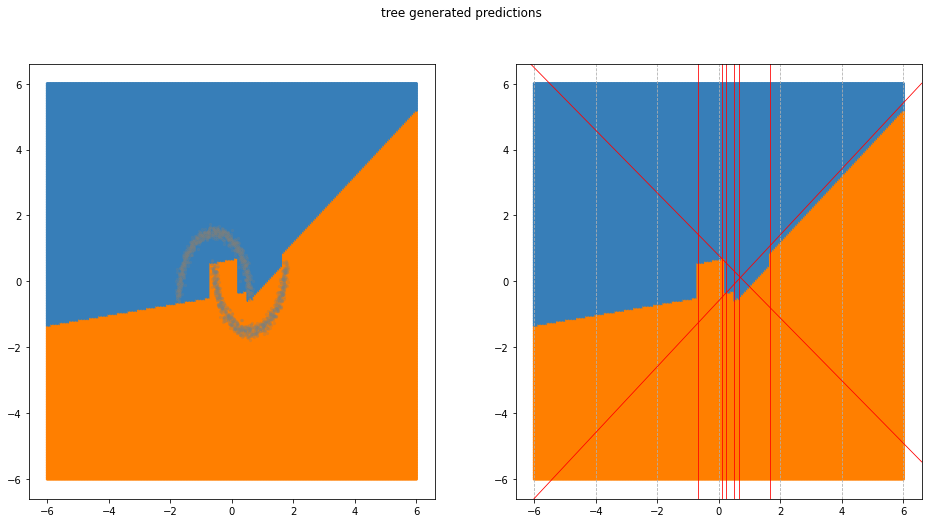

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('tree generated predictions')
fig

ax1.scatter(grid_x[:,0], grid_x[:,1], color = colors[grid_y_pred], s = 5)
ax1.scatter(moon_x[:,0], moon_x[:,1], color = 'gray', s = 5, alpha = 0.2)

ax2.scatter(grid_x[:,0], grid_x[:,1], color = colors[grid_y_pred], s = 5)
for node in nodes:
    if node._weights is not None and node._weights[0] == 1.:
        ax2.axvline(node._weights[-1], ymin = -10, ymax = 10, lw = 0.8, c = 'r')
ax2.axline((0, -0.5854), slope = 1, lw = 0.8, c = 'r')
ax2.axline((0, 0.7852), slope = -0.6885 / 0.7252, lw = 0.8, c = 'r')

plt.grid(axis = "x", linestyle = "--")